In [1]:
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

In [2]:
n = 10
max_bond = 5

In [3]:
### Macroscopic Quantities ###


# define c_i
c_left = -1  # c_0
c_mid = 0  # c_1
c_right = 1  # c_2


# density
def calc_rho(left, mid, right):
    sum = left + mid + right
    return sum


# velocity
def calc_rho_u(left, mid, right):
    rho = calc_rho(left, mid, right)
    sum = c_left * left + c_mid * mid + c_right * right
    u = sum / rho
    return rho, u

In [4]:
### colision step ###


# equilibrium terms
def calc_f_eq(
    w, coeff, left, mid, right
):  # w[i] are the weights, coeff[j] are the coefficients of the Taylor terms

    rho, u = calc_rho_u(left, mid, right)

    # left side
    left_eq = (
        w[0]
        * rho
        * (1 + coeff[0] * c_left * u + coeff[1] * c_left**2 * u**2 + coeff[2] * u**2)
    )

    # mid
    mid_eq = (
        w[1]
        * rho
        * (1 + coeff[0] * c_mid * u + coeff[1] * c_mid**2 * u**2 + coeff[2] * u**2)
    )

    # right side
    right_eq = (
        w[2]
        * rho
        * (1 + coeff[0] * c_right * u + coeff[1] * c_right**2 * u**2 + coeff[2] * u**2)
    )

    return left_eq, mid_eq, right_eq


# update step
def calc_f_star(tau, left_eq, mid_eq, right_eq, left, mid, right):

    # left side
    left_star = left + (left_eq - left) / tau

    # mid side
    mid_star = mid + (mid_eq - mid) / tau

    # right side
    right_star = right + (right_eq - right) / tau

    return left_star, mid_star, right_star

In [5]:
jnp.roll(jnp.arange(10), -4)

Array([4, 5, 6, 7, 8, 9, 0, 1, 2, 3], dtype=int64)

In [6]:
### streaming step ###


# update step
def calc_f_next(left_star, mid_star, right_star):
    # shift to the left
    left_next = jnp.roll(left_star, -1)

    # mid stays the same
    mid_next = mid_star

    # shift to the right
    right_next = jnp.roll(right_star, 1)

    return left_next, mid_next, right_next

In [7]:
### Boundaries ###


# swapping of directions on boundaries
def calc_boundaries(obstacles, left_next, mid_next, right_next):
    sum = left_next + right_next
    dif = left_next - right_next
    swapped_dif = (-2 * obstacles + 1) * dif

    left_swap = 0.5 * (sum + swapped_dif)
    mid_swap = mid_next
    right_swap = 0.5 * (sum - swapped_dif)
    return left_swap, mid_swap, right_swap

In [8]:
### time step ###


def advance_time(w, coeff, tau, obstacles, left, mid, right):
    left_eq, mid_eq, right_eq = calc_f_eq(w, coeff, left, mid, right)
    left_star, mid_star, right_star = calc_f_star(
        tau, left_eq, mid_eq, right_eq, left, mid, right
    )
    left_next, mid_next, right_next = calc_f_next(left_star, mid_star, right_star)
    left_swap, mid_swap, right_swap = calc_boundaries(
        obstacles, left_next, mid_next, right_next
    )
    return left_swap, mid_swap, right_swap

In [9]:
import numpy as np


# Define Gaussian and sine function
def gaussian(x, mu, sigma):
    return np.exp(
        -0.5 * ((x - mu) / sigma) ** 2
    )  # * (1 / (sigma * np.sqrt(2 * np.pi)))


def sine_squared(x, mu, offset):
    return np.sin(2 * np.pi * (x_values - mu)) ** 2 + offset


# resolution
N = 2**n
vec_shape = 2**n
mps_shape = (2,) * n

# x values from 0 to 1
x_values = np.linspace(0, 1, N)

# Mean (peak) in the middle
mu = 0.5

# linear velocity offset
offset = 0.5

# Standard deviation (adjust for desired width)
sigma = 0.05

# Generate Arrays with initial values
gauss_initial = 1 + gaussian(x_values, mu, sigma)
sin_initial = sine_squared(x_values, mu, offset)
zero_initial = np.zeros(N)

In [10]:
w = [1 / 6, 4 / 6, 1 / 6]
coeff = [3, 9 / 2, -3 / 2]
tau = 10
steps = 5 * N

vec_shape = 2**n
mps_shape = (2,) * n

left = jnp.array(zero_initial)  # f_0
mid = jnp.array(gauss_initial)  # f_1
right = jnp.array(zero_initial)  # f_2

obstacles = jnp.zeros(N).at[int(8 / 10 * N) : int(9 / 10 * N)].set(1)

jit_adv_time = jax.jit(advance_time)

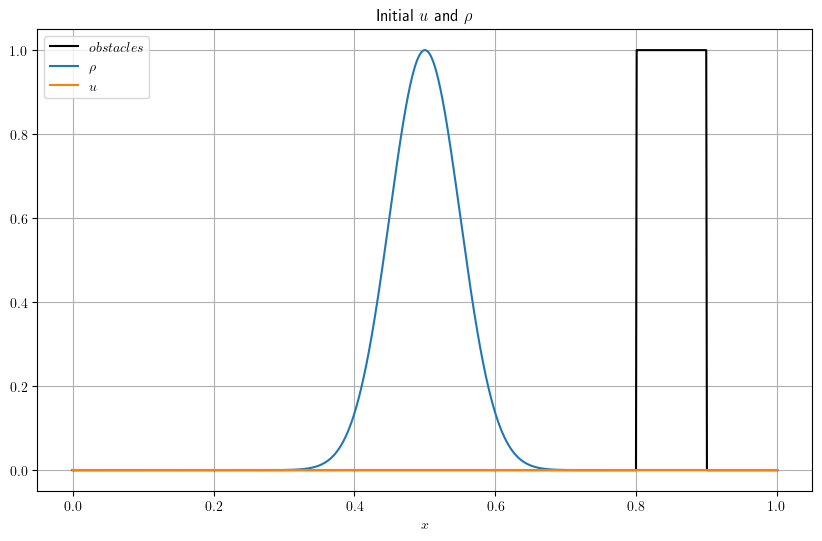

In [11]:
import matplotlib.pyplot as plt

plt.rcParams["text.usetex"] = True

rho, u = calc_rho_u(left, mid, right)
rho_initial = rho - 1
u_initial = u

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x_values, obstacles, label=r"$obstacles$", color="black")
plt.plot(x_values, rho_initial, label=r"$\rho$")
plt.plot(x_values, u, label=r"$u$")

# Customize the plot
plt.xlabel(r"$x$")
plt.title(r"Initial $u$ and $\rho$")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [12]:
data = []
rho, u = calc_rho_u(left, mid, right)
data.append([rho - 1, u])

In [13]:
left, mid, right = jit_adv_time(w, coeff, tau, obstacles, left, mid, right)

In [14]:
left, mid, right = jit_adv_time(w, coeff, tau, obstacles, left, mid, right)

In [15]:
clip_length = 5
fps = 30
interval = 1e3 / fps
frames_necessary = clip_length * fps

for i in range(2, steps):
    left, mid, right = jit_adv_time(w, coeff, tau, obstacles, left, mid, right)
    if i % int(steps / frames_necessary) == 0:
        rho, u = calc_rho_u(left, mid, right)
        data.append([rho - 1, u])
        print("at", int(100 * i / steps), "percent", end="\r")
print("finished!              ", end="\r")

In [16]:
import matplotlib.animation as animation
from IPython.display import HTML

# Create the animation
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_ylim([-0.5, 1.1])
plt.plot(x_values, obstacles, label=r"$obstacles$", color="black")
(line1,) = ax.plot(x_values, data[0][0], label=r"$\rho$")
(line2,) = ax.plot(x_values, data[0][1], label=r"$u$")


def animate(i):
    line1.set_ydata(data[i][0])  # Update the data
    line2.set_ydata(data[i][1])  # Update the data
    return line1, line2


ani = animation.FuncAnimation(
    fig, animate, frames=len(data), blit=True, interval=interval, repeat=False
)
plt.xlabel(r"$x$")
plt.legend()
plt.grid(True)
plt.title(r"Naive Solution")
plt.close()

# render the animation
HTML(ani.to_html5_video())